Few Details about the dataset

Content:

genres original - A collection of 10 genres with 100 audio files each, all having a length of 30 seconds (the famous GTZAN dataset, the MNIST of sounds)

images original - A visual representation for each audio file. One way to classify data is through neural networks. Because NNs (like CNN, what we will be using today) usually take in some sort of image representation, the audio files were converted to Mel Spectrograms to make this possible.

2 CSV files - Containing features of the audio files. One file has for each song (30 seconds long) a mean and variance computed over multiple features that can be extracted from an audio file. The other file has the same structure, but the songs were split before into 3 seconds audio files (this way increasing 10 times the amount of data we fuel into our classification models). With data, more is always better.

Importing all essential libraries

In [2]:
!pip install librosa

In [1]:
pip install numba==0.53


     |████████████████████████████████| 3.4 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 25.3 MB 716 kB/s eta 0:00:01     |██████████████████████▊         | 18.0 MB 986 kB/s eta 0:00:08
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.38.0
    Uninstalling llvmlite-0.38.0:
      Successfully uninstalled llvmlite-0.38.0
  Attempting uninstall: numba
    Found existing installation: numba 0.55.1
    Uninstalling numba-0.55.1:
      Successfully uninstalled numba-0.55.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Usual Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
general_path = '/home/kartik/Desktop/PRML Team Project/Data'
print(list(os.listdir(f'{general_path}/genres_original/')))

['disco', 'country', 'classical', 'reggae', 'blues', 'pop', 'rock', 'metal', 'jazz', 'hiphop']


# Exploring Audio Data

### Understanding Audio:

Let's first Explore our Audio Data to see how it looks (we'll work with reggae.00036.wav file).


* Sound: sequence of vibrations in varying pressure strengths (y)

* The sample rate (sr) is the number of samples of audio carried per second, measured in Hz or kHz

In [4]:
# Importing 1 file
y, sr = librosa.load(f'{general_path}/genres_original/reggae/reggae.00036.wav')

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

# Verify length of the audio
print('Check Len of Audio:', 661794/22050)

y: [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] 

y shape: (661794,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 30.013333333333332


In [5]:
# Trim leading and trailing silence from an audio signal (silence before and after the actual audio)
audio_file, _ = librosa.effects.trim(y)

# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] 

Audio File shape: (661794,)


2D Representation: Sound Waves

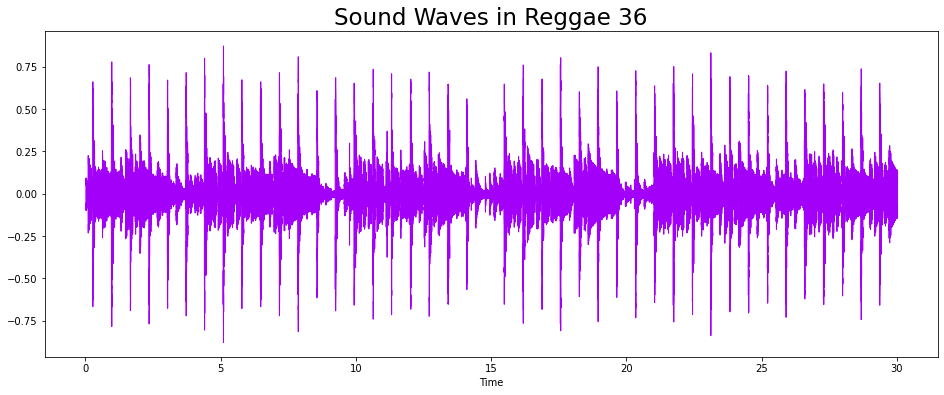

In [7]:
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio_file, sr = sr, color = "#A300F9");
plt.title("Sound Waves in Reggae 36", fontsize = 23);

### Fourier Transform
* Function that gets a signal in the time domain as input, and outputs its decomposition into frequencies
* Transform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is approx. the log scale of amplitudes.

In [8]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))

print('Shape of D object:', np.shape(D))

Shape of D object: (1025, 1293)


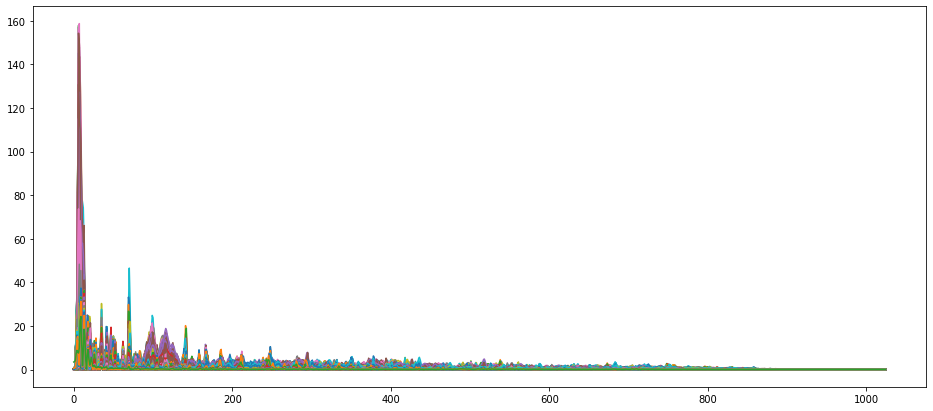

In [10]:
plt.figure(figsize = (16, 7))
plt.plot(D);

### The Spectrogram
* A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. When applied to an audio signal, spectrograms are sometimes called sonographs, voiceprints, or voicegrams

* Here we convert the frequency axis to a logarithmic one.

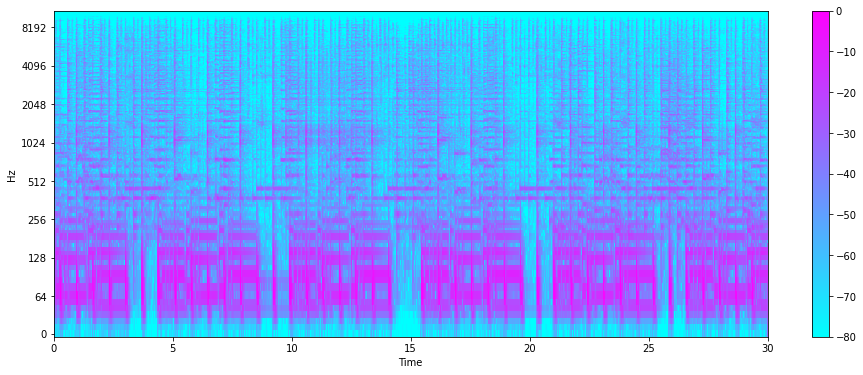

In [11]:
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the Spectogram
plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool')
plt.colorbar();

### MEL Spectrogram

* The Mel Scale, mathematically speaking, is the result of some non-linear transformation of the frequency scale. The Mel Spectrogram is a normal Spectrogram, but with a Mel Scale on the y axis.

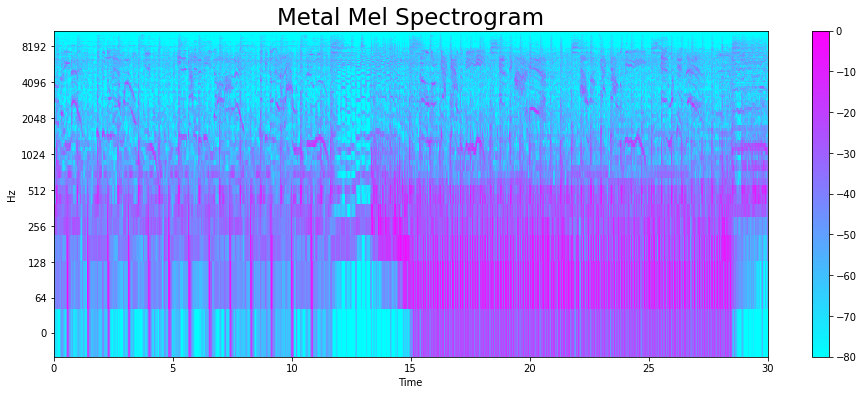

In [12]:
y, sr = librosa.load(f'{general_path}/genres_original/metal/metal.00036.wav')
y, _ = librosa.effects.trim(y)


S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool');
plt.colorbar();
plt.title("Metal Mel Spectrogram", fontsize = 23);

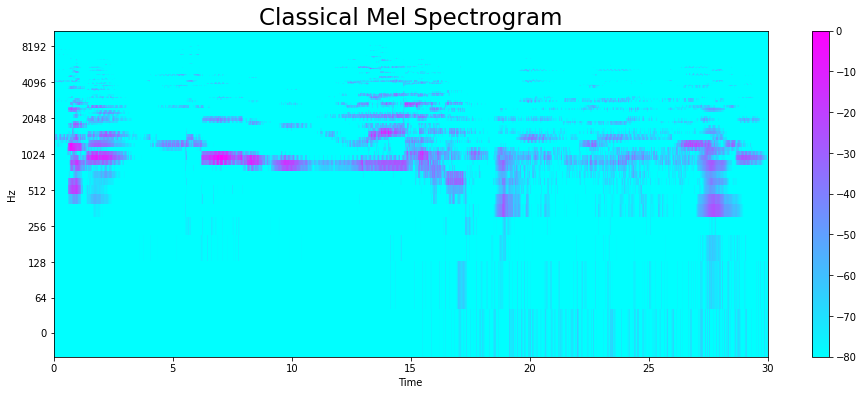

In [13]:
y, sr = librosa.load(f'{general_path}/genres_original/classical/classical.00036.wav')
y, _ = librosa.effects.trim(y)


S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool');
plt.colorbar();
plt.title("Classical Mel Spectrogram", fontsize = 23);

## Audio Features 

### Zero Crossing Rate 
* the rate at which the signal changes from positive to negative or back.

In [14]:
# Total zero_crossings in our 1 song
zero_crossings = librosa.zero_crossings(audio_file, pad=False)
print(sum(zero_crossings))

39232


### Harmonics and Perceptrual
* Harmonics are characteristichs that human ears can't distinguish (represents the sound color)
* Perceptrual understanding shock wave represents the sound rhythm and emotion

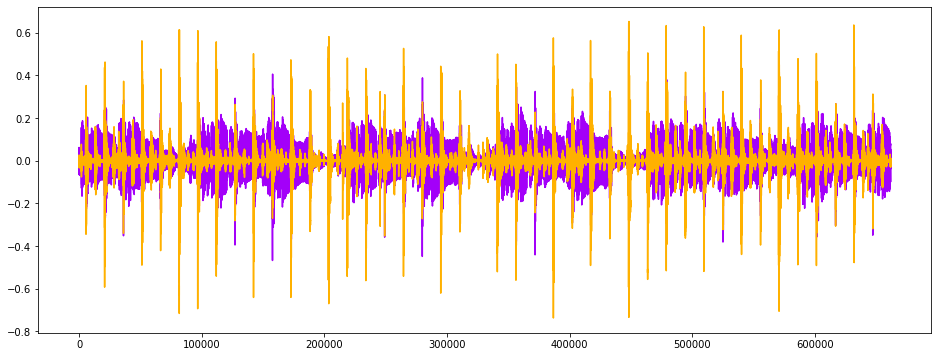

In [15]:
y_harm, y_perc = librosa.effects.hpss(audio_file)

plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9');
plt.plot(y_perc, color = '#FFB100');

### Tempo BMP (beats per minute)
Dynamic programming beat tracker

In [16]:
tempo, _ = librosa.beat.beat_track(y, sr = sr)
tempo

107.666015625

### Spectral Centroid
* indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound.

In [17]:
# Calculate the Spectral Centroids
spectral_centroids = librosa.feature.spectral_centroid(audio_file, sr=sr)[0]

# Shape is a vector
print('Centroids:', spectral_centroids, '\n')
print('Shape of Spectral Centroids:', spectral_centroids.shape, '\n')

# Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

print('frames:', frames, '\n')
print('t:', t)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

Centroids: [1758.29476432 1946.74243678 2038.8113414  ...  766.50416352 1041.07728901
 1391.05145642] 

Shape of Spectral Centroids: (1293,) 

frames: range(0, 1293) 

t: [0.00000000e+00 2.32199546e-02 4.64399093e-02 ... 2.99537415e+01
 2.99769615e+01 3.00001814e+01]


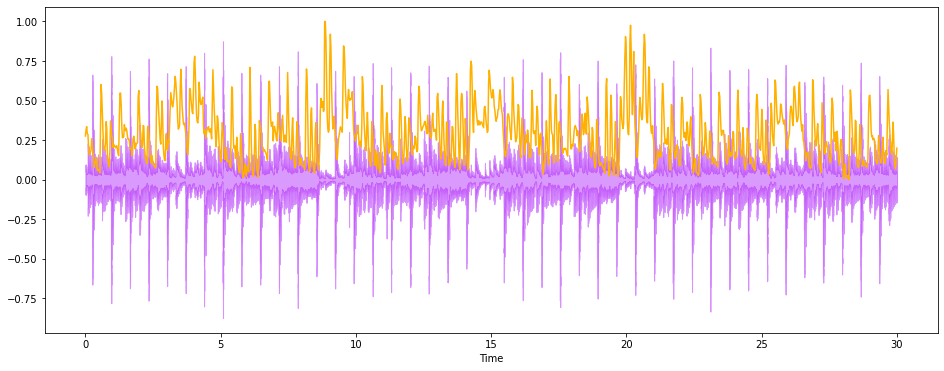

In [19]:
#Plotting the Spectral Centroid along the waveform
plt.figure(figsize = (16, 6))
librosa.display.waveshow(audio_file, sr=sr, alpha=0.4, color = '#A300F9');
plt.plot(t, normalize(spectral_centroids), color='#FFB100');

### Spectral Rolloff
* is a measure of the shape of the signal. It represents the frequency below which a specified percentage of the total spectral energy, e.g. 85%, lies

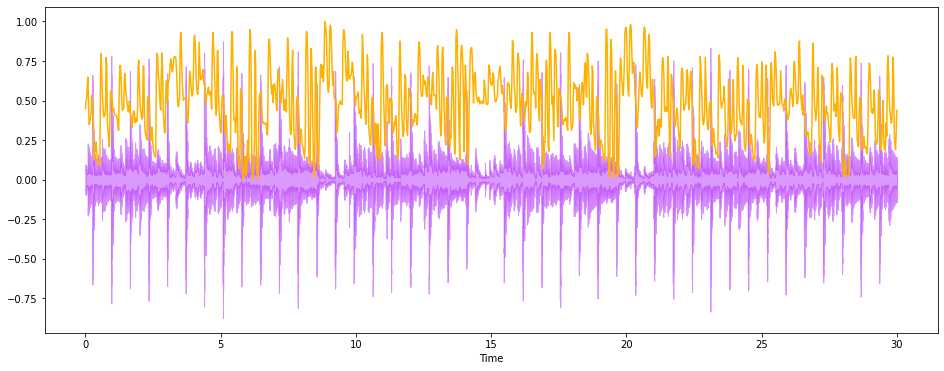

In [21]:
# Spectral RollOff Vector
spectral_rolloff = librosa.feature.spectral_rolloff(audio_file, sr=sr)[0]

# The plot
plt.figure(figsize = (16, 6))
librosa.display.waveshow(audio_file, sr=sr, alpha=0.4, color = '#A300F9');
plt.plot(t, normalize(spectral_rolloff), color='#FFB100');

### Mel-Frequency Cepstral Coefficients:
* The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. It models the characteristics of the human voice.

mfccs shape: (20, 1293)


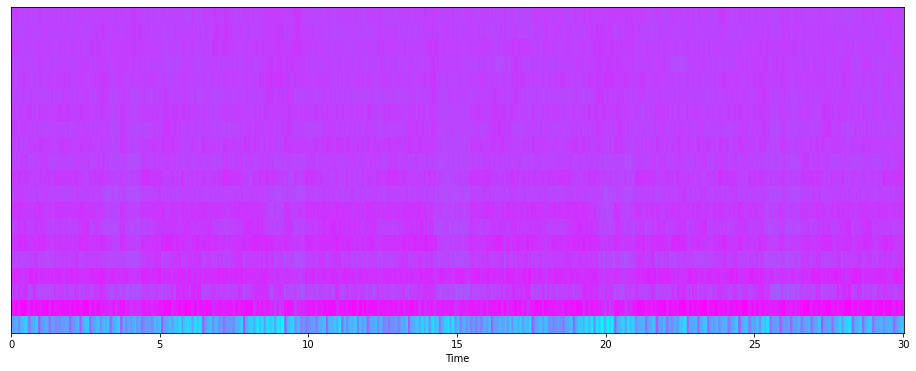

In [22]:
mfccs = librosa.feature.mfcc(audio_file, sr=sr)
print('mfccs shape:', mfccs.shape)

#Displaying  the MFCCs:
plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

Scaling the data

Mean: -8.8508056e-10 

Var: 1.0000001


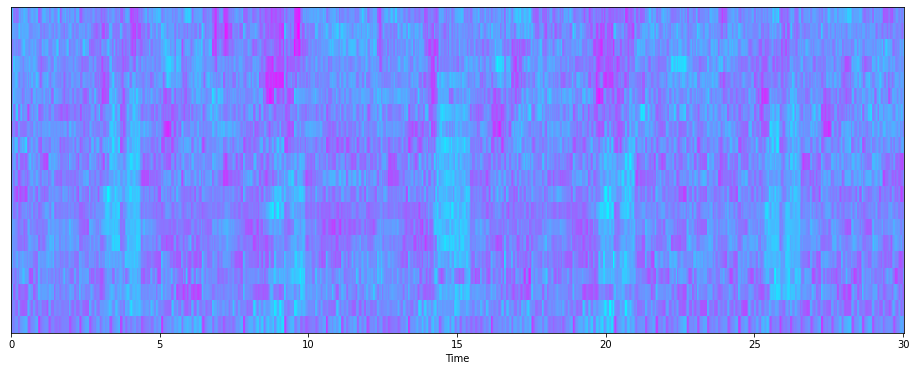

In [23]:
# Perform Feature Scaling
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print('Mean:', mfccs.mean(), '\n')
print('Var:', mfccs.var())

plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

### Chroma Frequencies
* Chroma features are an interesting and powerful representation for music audio in which the entire spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma) of the musical octave.

Chromogram shape: (12, 133)


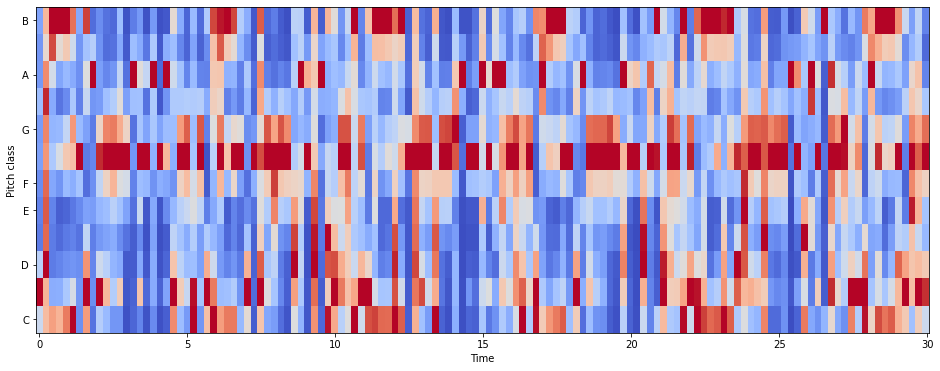

In [24]:
# Increase or decrease hop_length to change how granular you want your data to be
hop_length = 5000

# Chromogram
chromagram = librosa.feature.chroma_stft(audio_file, sr=sr, hop_length=hop_length)
print('Chromogram shape:', chromagram.shape)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm');

### EDA
EDA is going to be performed on the   features_30_sec.csv . This file contains the mean and variance for each audio file fo the features analysed above.

So, the table has a final of 1000 rows (10 genrex x 100 audio files) and 60 features (dimensionalities).

In [25]:
data = pd.read_csv(f'{general_path}/features_30_sec.csv')
data.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              2002.449060            85882.761315  ...   52.420910   
1              2039.036516           213843.755497  ...   55.356403   
2              1747.702312            76254.192257  ...   40.598766   
3              1596.412872           166441.494769  ...   44.427753   
4              1748.172116            88445.209036  ...   86.099236   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -1.690215   36.524071    -0.408979   41.597103    -2.303523   55.062923   
1    -0.731125   60.314529     0.295073   48.120598    -0.283518   51.106190   
2    -7.729093   47.639427    -1.816407   52.382141    -3.439720   46.639660   
3    -3.319597   50.206673     0.636965   37.319130    -0.619121   37.259739   
4    -5.454034   75.269707    -0.916874   53.613918    -4.404827   62.910812   

   mfcc20_mean  mfcc20_var  label  
0     1.221291   46.936035  blues  
1     0.531217   45.786282  blues  
2    -2.231258   30.573025  blues  
3    -3.407448   31.949339  blues  
4   -11.703234   55.195160  blues  

[5 rows x 60 columns]

In [26]:
data.shape

(1000, 60)

### Correlation Heatmap for feature means

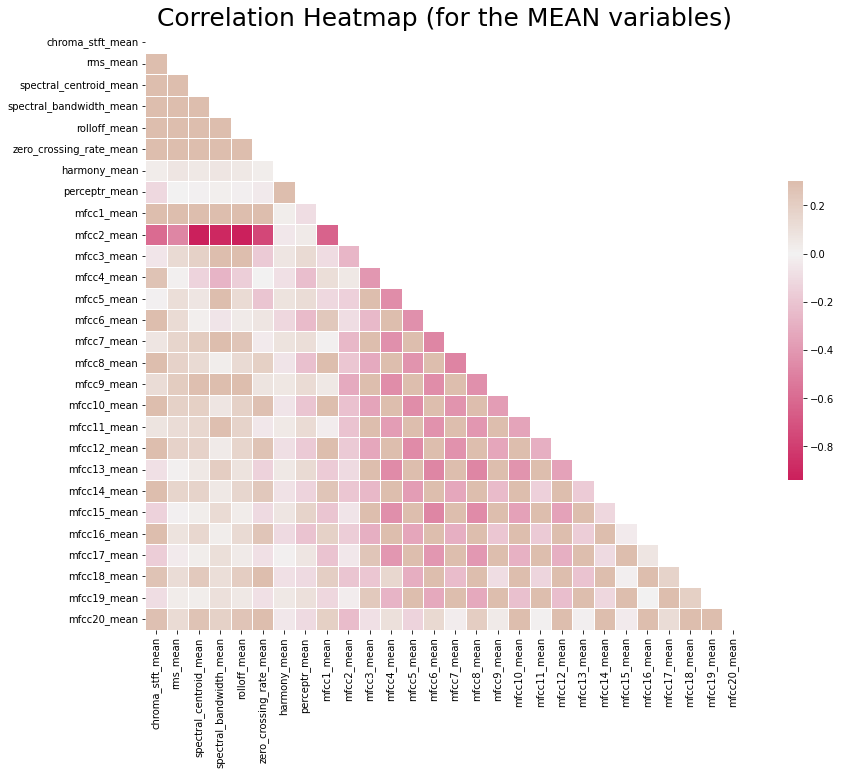

In [27]:
# Computing the Correlation Matrix
spike_cols = [col for col in data.columns if 'mean' in col]
corr = data[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr Heatmap.jpg")

### Box Plot for Genres Distributions

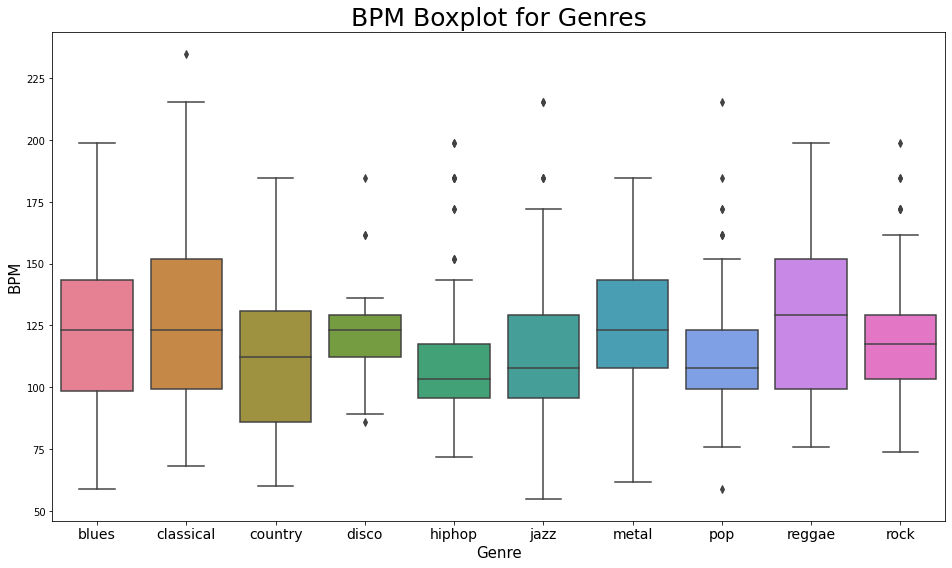

In [28]:
x = data[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM Boxplot.jpg")

### Principal Component Analysis - to visualize possible groups of genres

1. Normalisation 
2. PCA
3. The scatter plot

In [29]:
from sklearn import preprocessing

data = data.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

#### NORMALIZE X ####
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)


#### PCA 2 COMPONENTS ####
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

pca.explained_variance_ratio_

# 44.93 variance explained

array([0.2439355 , 0.21781804])

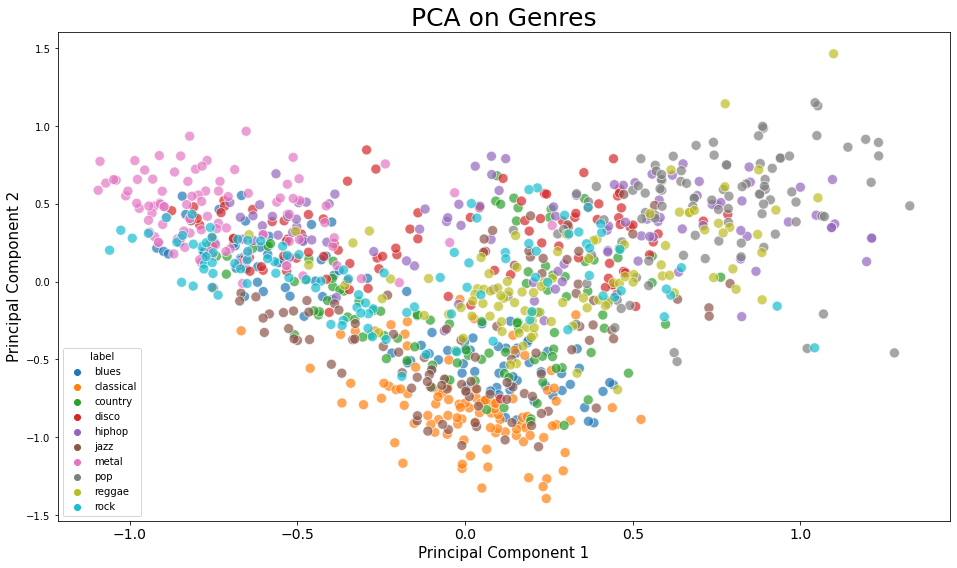

In [30]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('PCA on Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA Scattert.jpg")

### Machine Learning Classification
Using the features_3_sec.csv file, we can try to build a classifier that accurately predicts for any new audio file input it's genre.

In [33]:
!pip install xgboost

  Using cached xgboost-1.6.0-py3-none-manylinux2014_x86_64.whl (193.7 MB)


In [34]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [35]:
data = pd.read_csv(f'{general_path}/features_3_sec.csv')
data = data.iloc[0:, 1:] 
data.head()

length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0   66149          0.335406         0.091048  0.130405  0.003521   
1   66149          0.343065         0.086147  0.112699  0.001450   
2   66149          0.346815         0.092243  0.132003  0.004620   
3   66149          0.363639         0.086856  0.132565  0.002448   
4   66149          0.335579         0.088129  0.143289  0.001701   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1773.065032          167541.630869              1972.744388   
1             1816.693777           90525.690866              2010.051501   
2             1788.539719          111407.437613              2084.565132   
3             1655.289045          111952.284517              1960.039988   
4             1630.656199           79667.267654              1948.503884   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_var  mfcc17_mean  \
0           117335.771563   3714.560359  ...   39.687145    -3.241280   
1            65671.875673   3869.682242  ...   64.748276    -6.055294   
2            75124.921716   3997.639160  ...   67.336563    -1.768610   
3            82913.639269   3568.300218  ...   47.739452    -3.841155   
4            60204.020268   3469.992864  ...   30.336359     0.664582   

   mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  mfcc20_mean  \
0   36.488243     0.722209   38.099152    -5.050335   33.618073    -0.243027   
1   40.677654     0.159015   51.264091    -2.837699   97.030830     5.784063   
2   28.348579     2.378768   45.717648    -1.938424   53.050835     2.517375   
3   28.337118     1.218588   34.770935    -3.580352   50.836224     3.630866   
4   45.880913     1.689446   51.363583    -3.392489   26.738789     0.536961   

   mfcc20_var  label  
0   43.771767  blues  
1   59.943081  blues  
2   33.105122  blues  
3   32.023678  blues  
4   29.146694  blues  

[5 rows x 59 columns]

### Features and Target Variables 
* creates the target and feature variables 
* normalises the data

In [67]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
data['label']= label_encoder.fit_transform(data['label'])
data

length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0      66149          0.335406         0.091048  0.130405  0.003521   
1      66149          0.343065         0.086147  0.112699  0.001450   
2      66149          0.346815         0.092243  0.132003  0.004620   
3      66149          0.363639         0.086856  0.132565  0.002448   
4      66149          0.335579         0.088129  0.143289  0.001701   
...      ...               ...              ...       ...       ...   
9985   66149          0.349126         0.080515  0.050019  0.000097   
9986   66149          0.372564         0.082626  0.057897  0.000088   
9987   66149          0.347481         0.089019  0.052403  0.000701   
9988   66149          0.387527         0.084815  0.066430  0.000320   
9989   66149          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              1972.744388   
1                1816.693777           90525.690866              2010.051501   
2                1788.539719          111407.437613              2084.565132   
3                1655.289045          111952.284517              1960.039988   
4                1630.656199           79667.267654              1948.503884   
...                      ...                    ...                      ...   
9985             1499.083005          164266.886443              1718.707215   
9986             1847.965128          281054.935973              1906.468492   
9987             1346.157659          662956.246325              1561.859087   
9988             2084.515327          203891.039161              2018.366254   
9989             1634.330126          411429.169769              1867.422378   

      spectral_bandwidth_var  rolloff_mean  ...  mfcc16_var  mfcc17_mean  \
0              117335.771563   3714.560359  ...   39.687145    -3.241280   
1               65671.875673   3869.682242  ...   64.748276    -6.055294   
2               75124.921716   3997.639160  ...   67.336563    -1.768610   
3               82913.639269   3568.300218  ...   47.739452    -3.841155   
4               60204.020268   3469.992864  ...   30.336359     0.664582   
...                      ...           ...  ...         ...          ...   
9985            85931.574523   3015.559458  ...   42.485981    -9.094270   
9986            99727.037054   3746.694524  ...   32.415203   -12.375726   
9987           138762.841945   2442.362154  ...   78.228149    -2.524483   
9988            22860.992562   4313.266226  ...   28.323744    -5.363541   
9989           119722.211518   3462.042142  ...   38.801735   -11.598399   

      mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0      36.488243     0.722209   38.099152    -5.050335   33.618073   
1      40.677654     0.159015   51.264091    -2.837699   97.030830   
2      28.348579     2.378768   45.717648    -1.938424   53.050835   
3      28.337118     1.218588   34.770935    -3.580352   50.836224   
4      45.880913     1.689446   51.363583    -3.392489   26.738789   
...          ...          ...         ...          ...         ...   
9985   38.326839    -4.246976   31.049839    -5.625813   48.804092   
9986   66.418587    -3.081278   54.414265   -11.960546   63.452255   
9987   21.778994     4.809936   25.980829     1.775686   48.582378   
9988   17.209942     6.462601   21.442928     2.354765   24.843613   
9989   58.983097    -0.178517   55.761299    -6.903252   39.485901   

      mfcc20_mean  mfcc20_var  label  
0       -0.243027   43.771767      0  
1        5.784063   59.943081      0  
2        2.517375   33.105122      0  
3        3.630866   32.023678      0  
4        0.536961   29.146694      0  
...           ...         ...    ...  
9985     1.818823   38.966969      9  
9986     0.428857   18.697033      9  
9987    -0.299545   41.586990      9  
9988     0.675824   12.787750      9  
9989    -

In [68]:
y = data['label'] # genre variable.
X = data.loc[:, data.columns != 'label'] #select all columns but not the labels

#### NORMALIZE X ####

# Normalize so everything is on the same scale. 

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Creating a Predefined function to assess the accuracy of a model
* Input is the model
* fits the model on the training set
* predicts on the testing features 
* compares the predictions with the actual

In [71]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    #print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

### Trying 10 different models to assess their performance
We tried 10 classification models, the best performing model was XGBooster.

In [72]:
# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess(xgbrf, "Cross Gradient Booster (Random Forest)")

Accuracy Naive Bayes : 0.51952 

Accuracy Stochastic Gradient Descent : 0.65532 

Accuracy KNN : 0.80581 

Accuracy Decission trees : 0.64765 

Accuracy Random Forest : 0.81415 

Accuracy Support Vector Machine : 0.75409 

Accuracy Logistic Regression : 0.6977 

Accuracy Neural Nets : 0.67034 

Accuracy Cross Gradient Booster : 0.9009 

Accuracy Cross Gradient Booster (Random Forest) : 0.74575 



### XGBoost is the winner - 90% accuracy
* create the final model
* compute confusion matrix
* Compute Feature Importance

Accuracy : 0.9009 



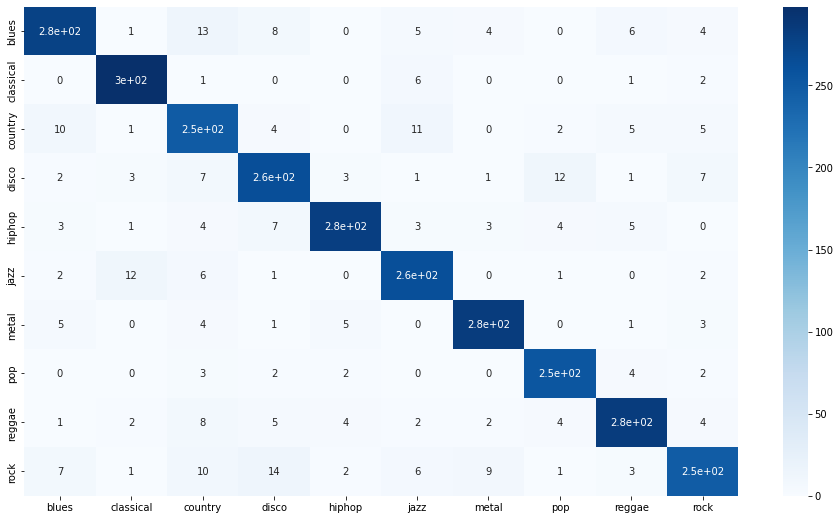

In [73]:
# Final model
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train)


preds = xgb.predict(X_test)

print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

# Confusion Matrix
confusion_matr = confusion_matrix(y_test, preds) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
plt.savefig("conf matrix")

### Recommender Systems
"Recomender" Systems enable us for any given vector to find the best similarity, ranked in descending order, from the bast match to the least best match.

For Audio files, this will be done through cosine_similarity library.

In [79]:
# Libraries
import IPython.display as ipd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing

# Read data
data = pd.read_csv(f'{general_path}/features_30_sec.csv', index_col='filename')

# Extract labels
labels = data[['label']]

# Drop labels from original dataframe
data = data.drop(columns=['length','label'])
data.head()

# Scale the data
data_scaled=preprocessing.scale(data)
print('Scaled data type:', type(data_scaled))

Scaled data type: <class 'numpy.ndarray'>


### Cosine similarity
Calculates the pairwise cosine similarity for each combination of songs in the data. This results in a 1000 x 1000 matrix (with redundancy in the information as item A similarity to item B == item B similarity to item A).

In [80]:
# Cosine similarity
similarity = cosine_similarity(data_scaled)
print("Similarity shape:", similarity.shape)

# Convert into a dataframe and then set the row index and column names as labels
sim_df_labels = pd.DataFrame(similarity)
sim_df_names = sim_df_labels.set_index(labels.index)
sim_df_names.columns = labels.index

sim_df_names.head()

Similarity shape: (1000, 1000)


filename         blues.00000.wav  blues.00001.wav  blues.00002.wav  \
filename                                                             
blues.00000.wav         1.000000         0.049231         0.589618   
blues.00001.wav         0.049231         1.000000        -0.096834   
blues.00002.wav         0.589618        -0.096834         1.000000   
blues.00003.wav         0.284862         0.520903         0.210411   
blues.00004.wav         0.025561         0.080749         0.400266   

filename         blues.00003.wav  blues.00004.wav  blues.00005.wav  \
filename                                                             
blues.00000.wav         0.284862         0.025561        -0.346688   
blues.00001.wav         0.520903         0.080749         0.307856   
blues.00002.wav         0.210411         0.400266        -0.082019   
blues.00003.wav         1.000000         0.126437         0.134796   
blues.00004.wav         0.126437         1.000000         0.556066   

filename         blues.00006.wav  blues.00007.wav  blues.00008.wav  \
filename                                                             
blues.00000.wav        -0.219483        -0.167626         0.641877   
blues.00001.wav         0.318286         0.415258         0.120649   
blues.00002.wav        -0.028061         0.104446         0.468113   
blues.00003.wav         0.300746         0.324566         0.352758   
blues.00004.wav         0.482195         0.623455         0.029703   

filename         blues.00009.wav  ...  rock.00090.wav  rock.00091.wav  \
filename                          ...                                   
blues.00000.wav        -0.097889  ...       -0.082829        0.546169   
blues.00001.wav         0.404168  ...       -0.098111       -0.325126   
blues.00002.wav        -0.132532  ...       -0.032408        0.561074   
blues.00003.wav         0.295184  ...       -0.320107       -0.206516   
blues.00004.wav         0.471657  ...        0.087605        0.017366   

filename         rock.00092.wav  rock.00093.wav  rock.00094.wav  \
filename                                                          
blues.00000.wav        0.578558        0.662590        0.571629   
blues.00001.wav       -0.370792       -0.191698       -0.330834   
blues.00002.wav        0.590779        0.583293        0.514537   
blues.00003.wav       -0.151132        0.041986       -0.172515   
blues.00004.wav        0.138035        0.104684       -0.034594   

filename         rock.00095.wav  rock.00096.wav  rock.00097.wav  \
filename                                                          
blues.00000.wav        0.610942        0.640835        0.496294   
blues.00001.wav       -0.077301       -0.222119       -0.302573   
blues.00002.wav        0.495707        0.566837        0.589983   
blues.00003.wav       -0.000287        0.020515       -0.107821   
blues.00004.wav        0.063454        0.063546        0.172944   

filename         rock.00098.wav  rock.00099.wav  
filename                                         
blues.00000.wav        0.284958        0.304098  
blues.00001.wav        0.499562        0.311723  
blues.00002.wav        0.216378        0.321069  
blues.00003.wav        0.502279        0.183210  
blues.00004.wav        0.153192        0.061785  

[5 rows x 1000 columns]

### Song similarity scoring
find_similar_songs() - is a predefined function that takes the name of the song and returns top 5 best matches for that song

In [81]:
def find_similar_songs(name):
    # Find songs most similar to another song
    series = sim_df_names[name].sort_values(ascending = False)
    
    # Remove cosine similarity == 1 (songs will always have the best match with themselves)
    series = series.drop(name)
    
    # Display the 5 top matches 
    print("\n*******\nSimilar songs to ", name)
    print(series.head(5))

### Putting the Similarity Function into Action:

In [86]:
!pip install playsound

  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7025 sha256=cc93c893785436944898c082e39084d6a7d49fb98797d8104860f2d81fa1a13c
  Stored in directory: /home/kartik/.cache/pip/wheels/73/cd/cf/9750b618d54bd81c20e4c34fb24a423a5b095920367cdb3f71
Successfully built playsound


In [90]:
from playsound import playsound

In [93]:
!pip install ffmpeg 

  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=cf9a080dd2dc571d0c27ce57a7c594f7b808236bf114752f7d4ec46d73bb67df
  Stored in directory: /home/kartik/.cache/pip/wheels/30/33/46/5ab7eca55b9490dddbf3441c68a29535996270ef1ce8b9b6d7
Successfully built ffmpeg


In [94]:
# pop.00019 - Britney Spears "Hit me baby one more time"
find_similar_songs('pop.00019.wav') 

ipd.Audio(f'{general_path}/genres_original/pop/pop.00019.wav')

#run the below command if the audio player isn't working
#playsound(f'{general_path}/genres_original/pop/pop.00019.wav')


*******
Similar songs to  pop.00019.wav
filename
pop.00023.wav    0.862836
pop.00034.wav    0.860499
pop.00078.wav    0.829135
pop.00088.wav    0.824456
pop.00091.wav    0.802269
Name: pop.00019.wav, dtype: float64


### Similar song match no.1
Britney Spears - I'm so curious (2009 remaster)

In [95]:
ipd.Audio(f'{general_path}/genres_original/pop/pop.00023.wav')


Similar song match no.2
Britney Spears - Sometimes

In [96]:
ipd.Audio(f'{general_path}/genres_original/pop/pop.00034.wav')


### METAL Example

In [98]:
# metal.00002 - Iron Maiden "Flight of Icarus"
find_similar_songs('metal.00002.wav') 

ipd.Audio(f'{general_path}/genres_original/metal/metal.00002.wav')

#playsound(f'{general_path}/genres_original/metal/metal.00002.wav')


*******
Similar songs to  metal.00002.wav
filename
metal.00028.wav    0.904367
metal.00059.wav    0.896096
rock.00018.wav     0.891910
rock.00017.wav     0.886526
rock.00016.wav     0.867508
Name: metal.00002.wav, dtype: float64


#### you can just play the above files in the similar fashion

# Using DEEP LEARNING (additional efforts)

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)

In [102]:
df = pd.read_csv(f'{general_path}/features_3_sec.csv')
df.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.051501            65671.875673  ...   64.748276   
2              2084.565132            75124.921716  ...   67.336563   
3              1960.039988            82913.639269  ...   47.739452   
4              1948.503884            60204.020268  ...   30.336359   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1    -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2    -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3    -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4     0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   

   mfcc20_mean  mfcc20_var  label  
0    -0.243027   43.771767  blues  
1     5.784063   59.943081  blues  
2     2.517375   33.105122  blues  
3     3.630866   32.023678  blues  
4     0.536961   29.146694  blues  

[5 rows x 60 columns]

In [103]:
print("Dataset has",df.shape)
print("Count of Positive and Negative samples")
df.label.value_counts().reset_index()

Dataset has (9990, 60)
Count of Positive and Negative samples


index  label
0      blues   1000
1       jazz   1000
2      metal   1000
3        pop   1000
4     reggae   1000
5      disco    999
6  classical    998
7     hiphop    998
8       rock    998
9    country    997

### Visualization

In [104]:
audio_fp = '/home/kartik/Desktop/PRML Team Project/Data/genres_original/blues/blues.00000.wav'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)

In [105]:
IPython.display.Audio(audio_data, rate=sr)

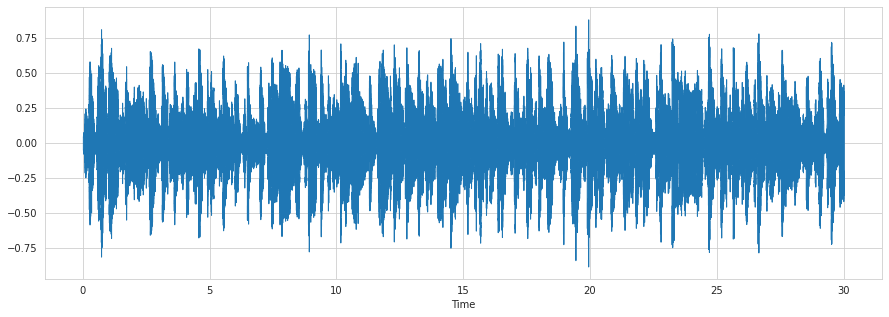

In [107]:
# plot sample file
plt.figure(figsize=(15,5))
lplt.waveshow(audio_data)
plt.show()

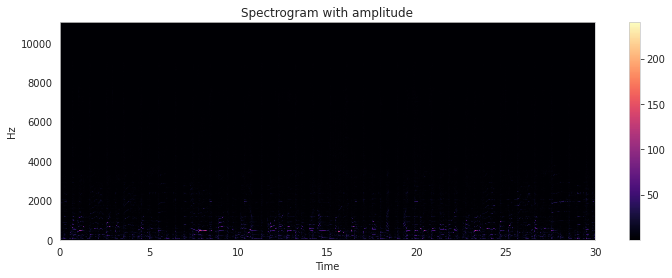

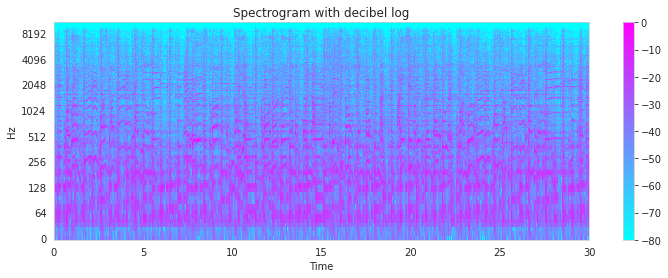

In [108]:
# Default FFT window size
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT

stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()

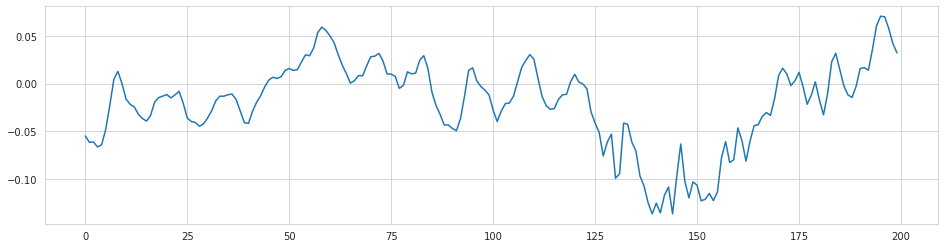

In [109]:
# plot zoomed audio wave 
start = 1000
end = 1200
plt.figure(figsize=(16,4))
plt.plot(audio_data[start:end])
plt.show()

### Data Preparation
* Treat missing values.
* Outlier Treatment
* Define dummy variables for categorical variables.

#### Missing Value Treatment

In [112]:
# find all columns with any NA values
print("Columns with NA values are",list(df.columns[df.isnull().any()]))

Columns with NA values are []


No null values in the dataset

There are no categorical variable as such. Hence, Dummy variable creation is not needed.

Encode Genre Label

In [113]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [114]:
# update labels in df to index
df.label = [label_index[l] for l in df.label]

### Split Train, Dev & Test Sets

In [115]:
# shuffle samples
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [116]:
# remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [117]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%


In [118]:
print(y_train.value_counts()[0]/y_train.shape[0]*100)
print(y_dev.value_counts()[0]/y_dev.shape[0]*100)
print(y_test.value_counts()[0]/y_test.shape[0]*100)

10.01001001001001
10.010111223458038
10.009813542688912


### Scale the Features

In [119]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

### Deep Learning Model Building

In [121]:
!pip install tensorflow

     |████████████████████████████████| 497.6 MB 994 bytes/s  0:00:013  |                                | 1.1 MB 2.0 MB/s eta 0:04:14     |▊                               | 11.1 MB 3.0 MB/s eta 0:02:42     |█▉                              | 28.8 MB 660 kB/s eta 0:11:50     |██▌                             | 39.6 MB 2.5 MB/s eta 0:03:02     |███▏                            | 49.2 MB 2.4 MB/s eta 0:03:06     |███▏                            | 49.5 MB 2.4 MB/s eta 0:03:06     |██████                          | 92.2 MB 6.8 MB/s eta 0:01:00     |████████                        | 125.1 MB 3.5 MB/s eta 0:01:46     |█████████▏                      | 142.1 MB 3.5 MB/s eta 0:01:41     |█████████▉                      | 153.6 MB 4.5 MB/s eta 0:01:17     |███████████▉                    | 183.8 MB 787 kB/s eta 0:06:39     |█████████████▎                  | 205.9 MB 10.1 MB/s eta 0:00:29     |██████████████▉                 | 230.4 MB 34.1 MB/s eta 0:00:08     |████████████████▊               | 25

In [122]:
import tensorflow as tf
print("TF version:-", tf.__version__)
import keras as k
tf.random.set_seed(seed)

2022-04-20 13:47:07.229979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-20 13:47:07.230052: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TF version:- 2.8.0


In [123]:
ACCURACY_THRESHOLD = 0.94

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

def trainModel(model, epochs, optimizer):
    batch_size = 128
    callback = myCallback()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy'
    )
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, 
                     batch_size=batch_size, callbacks=[callback])

def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

In [124]:
model_1 = k.models.Sequential([
    k.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dense(10, activation='softmax'),
])
print(model_1.summary())
model_1_history = trainModel(model=model_1, epochs=70, optimizer='adam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               14848     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 56,650
Trainable params: 56,650
Non-trainable params: 0
_________________________________________________________________


2022-04-20 13:47:36.681905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-20 13:47:36.681989: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-20 13:47:36.682031: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kartik-virtual-machine): /proc/driver/nvidia/version does not exist
2022-04-20 13:47:36.682534: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


None
Epoch 1/70
55/55 [==============================] - 2s 14ms/step - loss: 1.4898 - accuracy: 0.4842 - val_loss: 1.0579 - val_accuracy: 0.6304
Epoch 2/70
55/55 [==============================] - 1s 12ms/step - loss: 0.8929 - accuracy: 0.7000 - val_loss: 0.8233 - val_accuracy: 0.7139
Epoch 3/70
55/55 [==============================] - 1s 11ms/step - loss: 0.6921 - accuracy: 0.7696 - val_loss: 0.6955 - val_accuracy: 0.7644
Epoch 4/70
55/55 [==============================] - 1s 9ms/step - loss: 0.5704 - accuracy: 0.8131 - val_loss: 0.6420 - val_accuracy: 0.7730
Epoch 5/70
55/55 [==============================] - 1s 9ms/step - loss: 0.4888 - accuracy: 0.8384 - val_loss: 0.6093 - val_accuracy: 0.7978
Epoch 6/70
55/55 [==============================] - 1s 10ms/step - loss: 0.4109 - accuracy: 0.8650 - val_loss: 0.5376 - val_accuracy: 0.8109
Epoch 7/70
55/55 [==============================] - 1s 14ms/step - loss: 0.3459 - accuracy: 0.8897 - val_loss: 0.4969 - val_accuracy: 0.8311
Epoch 8/70

Max. Validation Accuracy 0.8963599801063538


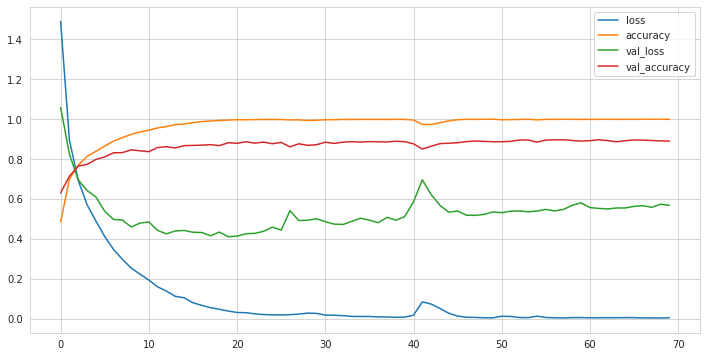

In [125]:
plotHistory(model_1_history)

In [126]:
model_2 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_2.summary())
model_2_history = trainModel(model=model_2, epochs=100, optimizer='adam')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               29696     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)               

Max. Validation Accuracy 0.926188051700592


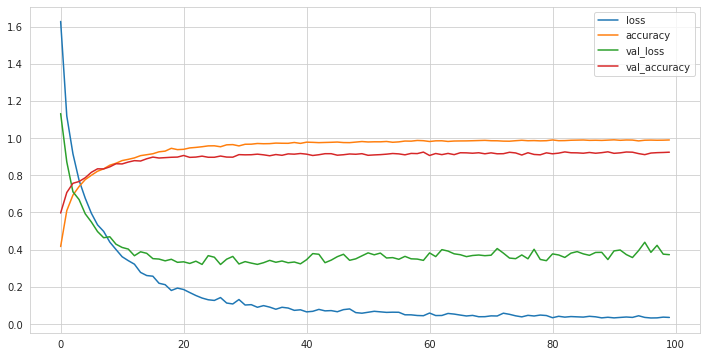

In [127]:
plotHistory(model_2_history)


In [128]:
model_3 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_3.summary())
model_3_history = trainModel(model=model_3, epochs=700, optimizer='sgd')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               29696     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 64)               

Max. Validation Accuracy 0.9186046719551086


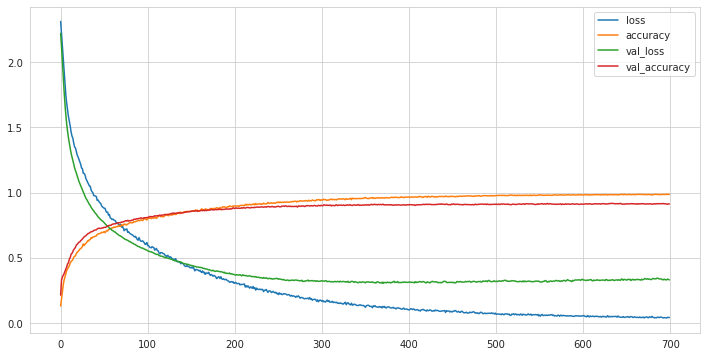

In [129]:
plotHistory(model_3_history)

In [130]:
model_4 = k.models.Sequential([
    k.layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.3),
    
    k.layers.Dense(512, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(10, activation='softmax'),
])
print(model_4.summary())
model_4_history = trainModel(model=model_4, epochs=500, optimizer='rmsprop')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 1024)              59392     
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               524800    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 128)              

Max. Validation Accuracy 0.9398382306098938


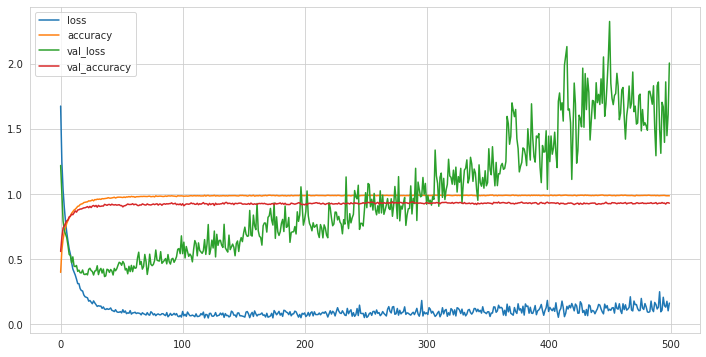

In [131]:
plotHistory(model_4_history)


### Model Evaluation

In [132]:
test_loss, test_acc  = model_4.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is :",test_loss)
print("\nThe Best test Accuracy is :",test_acc*100)

8/8 [==============================] - 0s 5ms/step - loss: 1.6831 - accuracy: 0.9244
The test Loss is : 1.6831086874008179

The Best test Accuracy is : 92.44357347488403


In [133]:
print(y_test)


9859    6
4702    5
9656    5
2016    1
3908    6
       ..
7221    8
634     4
4022    6
1081    1
1988    2
Name: label, Length: 1019, dtype: int64


In [134]:
dict2={0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
predicted_values=pd.DataFrame(y_test)
predicted_values=predicted_values.replace({"label":dict2})
predicted_values.reset_index(drop=True, inplace=True)
predicted_values=list(predicted_values.label)
i=0
for item in predicted_values:
    print("The prediction of song no. {} in our dataset is {}".format(i,item))
    i=i+1

The prediction of song no. 0 in our dataset is metal
The prediction of song no. 1 in our dataset is jazz
The prediction of song no. 2 in our dataset is jazz
The prediction of song no. 3 in our dataset is classical
The prediction of song no. 4 in our dataset is metal
The prediction of song no. 5 in our dataset is jazz
The prediction of song no. 6 in our dataset is classical
The prediction of song no. 7 in our dataset is pop
The prediction of song no. 8 in our dataset is hiphop
The prediction of song no. 9 in our dataset is jazz
The prediction of song no. 10 in our dataset is metal
The prediction of song no. 11 in our dataset is rock
The prediction of song no. 12 in our dataset is pop
The prediction of song no. 13 in our dataset is jazz
The prediction of song no. 14 in our dataset is classical
The prediction of song no. 15 in our dataset is pop
The prediction of song no. 16 in our dataset is rock
The prediction of song no. 17 in our dataset is hiphop
The prediction of song no. 18 in our 

### Analysing Results



In [135]:
y_pred_test=predicted_values[1:500]
print("Out of first 500 Songs total Classical Songs are {}".format(y_pred_test.count('classical')))
print("Out of 500 Songs total Pop Songs are {}".format(y_pred_test.count('pop')))
print("Out of first 500 Songs total Disco Songs are {}".format(y_pred_test.count('disco')))
print("Out of first 500 Songs total Jazz Songs are {}".format(y_pred_test.count('jazz')))
print("Out of first 500 Songs total Metal Songs are {}".format(y_pred_test.count('metal')))
print("Out of first 500 Songs total Hiphop Songs are {}".format(y_pred_test.count('hiphop')))
print("Out of first 500 Songs total Rock Songs are {}".format(y_pred_test.count('rock')))
print("Out of first 500 Songs total Reggae Songs are {}".format(y_pred_test.count('reggae')))
print("Out of first 500 Songs total Blues Songs are {}".format(y_pred_test.count('blues')))
print("Out of first 500 Songs total Country Songs are {}".format(y_pred_test.count('country')))

Out of first 500 Songs total Classical Songs are 45
Out of 500 Songs total Pop Songs are 47
Out of first 500 Songs total Disco Songs are 53
Out of first 500 Songs total Jazz Songs are 47
Out of first 500 Songs total Metal Songs are 47
Out of first 500 Songs total Hiphop Songs are 48
Out of first 500 Songs total Rock Songs are 53
Out of first 500 Songs total Reggae Songs are 54
Out of first 500 Songs total Blues Songs are 59
Out of first 500 Songs total Country Songs are 46


### Music Genre Clssification using CNN (Additional effort)

Dataset splitting

In [138]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33)


In [141]:
print(len(y_train))
print(len(y_test))

6693
3297


### Building the model

In [142]:
from tensorflow.keras.models import Sequential


In [143]:
def trainModel(model,epochs,optimizer):
    batch_size=128
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics='accuracy')
    return model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=batch_size)

In [144]:
def plotValidate(history):
    print("Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

In [147]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import scipy
import os
import pickle
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras

In [148]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(512,activation='relu',input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(256,activation='relu'),
    keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(10,activation='softmax'),
])

print(model.summary())
model_history=trainModel(model=model,epochs=600,optimizer='adam')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 512)               30208     
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_23 (Dense)            (None, 256)               131328    
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_24 (Dense)            (None, 128)               32896     
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 64)               

### Model Evaluation

In [149]:
test_loss,test_acc=model.evaluate(X_test,y_test,batch_size=128)
print("The test loss is ",test_loss)
print("The best accuracy is: ",test_acc*100)

26/26 [==============================] - 0s 4ms/step - loss: 0.4139 - accuracy: 0.9157
The test loss is  0.41392242908477783
The best accuracy is:  91.56809449195862


For the CNN model, we had used the Adam optimizer for training the model. The epoch that was chosen for the training model is 600. All of the hidden layers are using the RELU activation function and the output layer uses the softmax function. The loss is calculated using the sparse_categorical_crossentropy function. Dropout is used to prevent overfitting. We chose the Adam optimizer because it gave us the best results after evaluating other optimizers. The model accuracy can be increased by further increasing the epochs but after a certain period, we may achieve a threshold, so the value should be determined accordingly.

The model accuracy can be increased by further increasing the epochs but after a certain period, we may achieve a threshold, so the value should be determined accordingly. The accuracy we achieved for the test set is 92.14 percent which is very decent. So we come to the conclusion that Neural Networks are very effective in machine learning models. Tensorflow is very useful in implementing Convolutional Neural Network (CNN) that helps in the classifying process.